In [1]:
import tensorflow as tf
import numpy as np 
import tqdm as tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
import pandas as pd
import cv2 as cv

import re





2025-06-14 17:54:25.072480: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [3]:
imgPath  = '/Users/mac/Documents/Chat-Bot-Telegram/DataSet/Images'
data = pd.read_csv('/Users/mac/Documents/Chat-Bot-Telegram/DataSet/captions.txt')
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


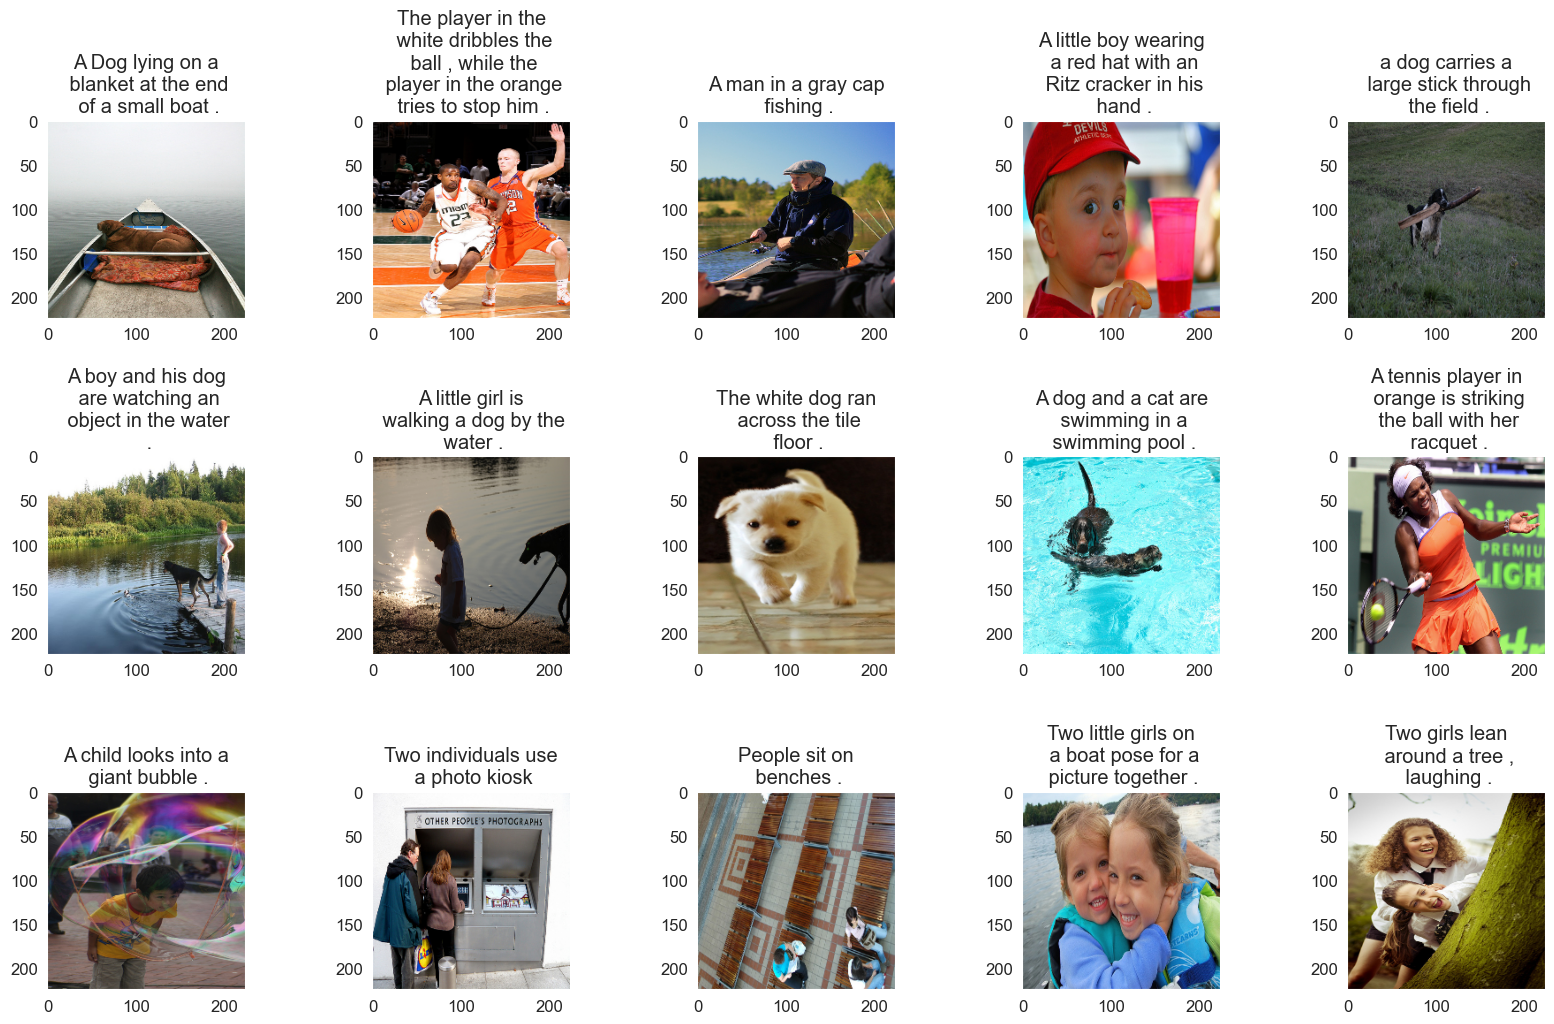

In [4]:
def read_image(imgPath):
    #img =load_img(path,color = 'rgn',target_size=(img_size,img_size))
    img = cv.imread(imgPath)
    img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    img = cv.resize(img, (224, 224)) 
    img = img / 255.0
    return img


def display_image(temp_info):
        temp_df = temp_info.reset_index(drop = True)
        plt.figure(figsize=(20,20))
        n = 0
        for i in range(15):
            n+=1
            plt.subplot(5,5,n)
            plt.subplots_adjust(hspace= 0.7,wspace=0.3)
            img_name = temp_df['image'][i] 
            imgPath  = f"/Users/mac/Documents/Chat-Bot-Telegram/DataSet/Images/{img_name}"
            img = read_image(imgPath)
            caption = ('\n '.join(wrap(temp_df['caption'][i],20)))

            plt.imshow(img)
            plt.title(caption)
display_image(data.sample(15))    

In [5]:
def text_propagation():
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: re.sub(r'[^a-z\s]', ' ', x))
    data['caption'] = data['caption'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())
    data['caption'] = data['caption'].apply(lambda x: ' '.join([word for word in x.split() if len(word) >1 ]))
    data['caption'] = data['caption'].apply(
    lambda x: ('startseq ' if not x.startswith('startseq') else '') +
              re.sub(r'\bstartseq\b(?:\s+startseq)+', 'startseq', x.strip()) + 
              (' endseq' if not x.strip().endswith('endseq') else '')
)

    
text_propagation()
print(data)


                           image  \
0      1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg   
...                          ...   
40450   997722733_0cb5439472.jpg   
40451   997722733_0cb5439472.jpg   
40452   997722733_0cb5439472.jpg   
40453   997722733_0cb5439472.jpg   
40454   997722733_0cb5439472.jpg   

                                                 caption  
0      startseq child in pink dress is climbing up se...  
1        startseq girl going into wooden building endseq  
2      startseq little girl climbing into wooden play...  
3      startseq little girl climbing the stairs to he...  
4      startseq little girl in pink dress going into ...  
...                                                  ...  
40450  startseq man in pink shirt climbs rock face en...  
40451  startseq man is rock climbing high in the air ...  
40452  startseq person in red shirt 

In [6]:
tokenizer = Tokenizer()
numreic = tokenizer.fit_on_texts(data['caption'])
vocabSize = len(tokenizer.word_index) +1

max_lenghth = max([ len(caption.split()) for caption in data['caption']])
print(max_lenghth)

image = data['image'].unique().tolist()
nimages = len(image)
split_index = round(0.85 * nimages)
train_image = image[:split_index]
val_image = image[split_index:]
train = data[data['image'].isin(train_image)]
print(train)
test = data[data['image'].isin(val_image)]
train.reset_index(inplace=True,drop = True)
test.reset_index(inplace=True,drop = True)
textoseq  = tokenizer.texts_to_sequences(data['caption'])
padd = pad_sequences(textoseq)
embedDim = 50
print(vocabSize)

35
                           image  \
0      1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg   
...                          ...   
34380  3688839836_ba5e4c24fc.jpg   
34381  3688839836_ba5e4c24fc.jpg   
34382  3688839836_ba5e4c24fc.jpg   
34383  3688839836_ba5e4c24fc.jpg   
34384  3688839836_ba5e4c24fc.jpg   

                                                 caption  
0      startseq child in pink dress is climbing up se...  
1        startseq girl going into wooden building endseq  
2      startseq little girl climbing into wooden play...  
3      startseq little girl climbing the stairs to he...  
4      startseq little girl in pink dress going into ...  
...                                                  ...  
34380  startseq woman is holding out peace sign durin...  
34381  startseq woman wearing red scarf raises her ha...  
34382  startseq people in orange 

In [ ]:
model = DenseNet201()

fe = model(input = model.input,  output = model.layers[-2].output )



NameError: name 'DenseNet201' is not defined